In [3]:
#neural network with momentum 
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
#load the data
dataset = pd.read_csv('train.csv',dtype = np.float32)
print dataset.shape
dataset.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data = dataset.iloc[:,1:].values
labels = dataset.iloc[:,0].values.reshape(-1,1)
print data.shape,labels.shape

(42000, 784) (42000, 1)


[ 6.]
[ 9.]
[ 9.]
[ 9.]
[ 7.]


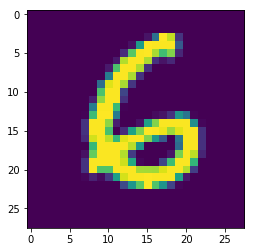

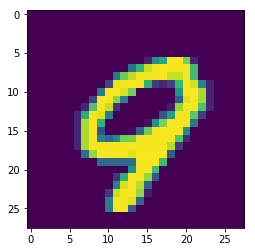

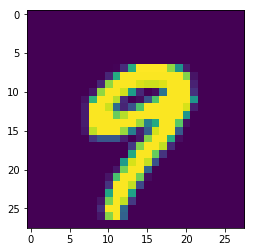

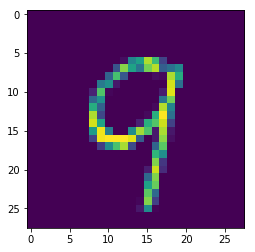

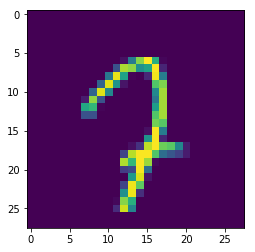

In [6]:
pixel_size = 28
#visualizing random samples from data
for i in np.random.randint(0,dataset.shape[0],5):
    temp = data[i,:].reshape(pixel_size,pixel_size)
    plt.figure()
    plt.imshow(temp)
    print labels[i,:]

In [7]:
from sklearn.decomposition import PCA

def reduce_dimension(data,n):
    pca = PCA(n_components = n_components)
    data = pca.fit_transform(data)
    return data

In [8]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
scaler_x = StandardScaler()
data = scaler_x.fit_transform(data)

ohc  = OneHotEncoder()
labels = ohc.fit_transform(labels).toarray()
print data.shape,labels.shape

(42000, 784) (42000, 10)


In [9]:
#splitting the data in train and test sets
def split(data,labels,test_size = 0.1):
    n = labels.shape[0]
    perm = np.random.permutation(n)
    data = data[perm,:]
    labels = labels[perm,:]
    train_x,test_x = data[:-int(test_size*n),:],data[-int(test_size*n):,:]
    train_y,test_y = labels[:-int(test_size*n),:],labels[-int(test_size*n):,:]
    return train_x,test_x,train_y,test_y

train_x,test_x,train_y,test_y = split(data,labels)
print "Training : ",train_x.shape,train_y.shape
print "Testing : ",test_x.shape,test_y.shape

Training :  (37800, 784) (37800, 10)
Testing :  (4200, 784) (4200, 10)


In [10]:
#model

def relu(x):
    return np.maximum(x,0)

def softmax(x):
    return np.exp(-x)/(np.sum(np.exp(-x),axis=1,keepdims=True))

def relu_grad(x):
    temp = np.zeros(x.shape)
    temp[x > 0] = 1
    return temp

def forward_prop(data,w1,b1,w2,b2):

    z1 = np.dot(data,w1) + b1
    a1 = relu(z1)
    #print 'a1',a1[:10,:10]
    z2 = np.dot(a1,w2) + b2
    a2 = softmax(z2)
    #print 'a2 : ',a2[:10,:]
    return a2,z2,a1,z1

def compute_loss(data,labels,weights,reg_param):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    a2,z2,a1,z1 = forward_prop(data,w1,b1,w2,b2)
    l = -np.sum(np.sum(labels*np.log(a2)))/labels.shape[0]
    l += (reg_param/2.0)*(np.sum(np.sum(w1**2)) + np.sum(np.sum(w2**2)))/labels.shape[0]
    return l,[z1,a1,z2,a2]

def compute_gradients(x,y,logits,weights,reg_param):
    z1,a1,z2,a2 = logits[0],logits[1],logits[2],logits[3]
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    
    de = -(y-a2)/y.shape[0]
    dw2 = np.dot(a1.T,de) + reg_param*w2/y.shape[0]
    db2 = np.sum(de,axis=0,keepdims=True)
    
    de = np.dot(de,w2.T)*relu_grad(z1)
    dw1 = np.dot(x.T,de) + reg_param*w1/y.shape[0]
    db1 = np.sum(de,axis=0,keepdims=True)
#     print 'w1',dw1[:10,:10]
#     print 'b1',db1[:,:10]
#     print 'w2',dw2[:10,:10]
#     print 'b2',db2[:,:10]
    return [dw1,db1,dw2,db2]
 
def update_weights_momentum(weights,grads,lr,velocity,mu):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    dw1,db1,dw2,db2 = grads[0],grads[1],grads[2],grads[3]
    vw1,vb1,vw2,vb2 = velocity[0],velocity[1],velocity[2],velocity[3]
    
    vw1 = mu*vw1 + lr*dw1
    vb1 = mu*vb1 + lr*db1
    vw2 = mu*vw2 + lr*dw2
    vb2 = mu*vb2 + lr*db2
    
    w1 += (mu**2)*vw1 + (1+mu)*lr*dw1
    b1 += (mu**2)*vb1 + (1+mu)*lr*db1
    w2 += (mu**2)*vw2 + (1+mu)*lr*dw2
    b2 += (mu**2)*vb2 + (1+mu)*lr*db2
    
    return w1,b1,w2,b2,[vw1,vb1,vw2,vb2]

def update_weights(weights,grads,learning_rate):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    dw1,db1,dw2,db2 = grads[0],grads[1],grads[2],grads[3]
    
    w1 += learning_rate*dw1
    b1 += learning_rate*db1
    w2 += learning_rate*dw2
    b2 += learning_rate*db2
    
    return w1,b1,w2,b2

def compute_accuracy(data,labels,weights):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    predictions,_,_,_ = forward_prop(data,w1,b1,w2,b2)
    val = np.sum(np.argmax(labels,axis=1) == np.argmax(predictions,axis=1))/labels.shape[0]
    return val

Training loss at step 0 is 2.72
Test accuracy at step 0 is 4.67%


Training loss at step 100 is 2.34
Test accuracy at step 100 is 18.00%


Training loss at step 200 is 2.09
Test accuracy at step 200 is 39.26%


Training loss at step 300 is 1.84
Test accuracy at step 300 is 52.98%


Training loss at step 400 is 1.62
Test accuracy at step 400 is 60.86%


Training loss at step 500 is 1.49
Test accuracy at step 500 is 66.29%


Training loss at step 600 is 1.38
Test accuracy at step 600 is 69.93%


Training loss at step 700 is 1.23
Test accuracy at step 700 is 72.12%


Training loss at step 800 is 1.21
Test accuracy at step 800 is 74.19%


Training loss at step 900 is 1.13
Test accuracy at step 900 is 75.86%


Training loss at step 1000 is 1.12
Test accuracy at step 1000 is 77.33%




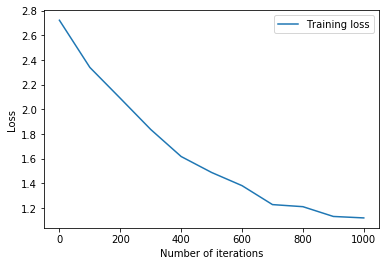

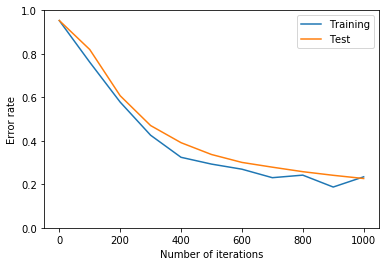

In [11]:
#hyperparamters
n,m = train_x.shape
learning_rate = 0.001
reg_param = 0.2
nh1 = 300
p = train_y.shape[1]
n_iter = 1001
batch_size = 256
print_period = 100
mu = 0.99

#weights 
w1 = np.random.randn(m,nh1)/28
b1 = np.zeros((1,nh1))
w2 = np.random.randn(nh1,p)/np.sqrt(nh1)
b2 = np.zeros((1,p))
weights = [w1,b1,w2,b2]

#training the model
train_loss = []
test_errs = []
train_errs = []

for step in range(n_iter):
    k = (step*batch_size) % (n - batch_size)
    batch_x = train_x[k:(k+batch_size)]
    batch_y = train_y[k:(k+batch_size)]
    
    l,logits = compute_loss(batch_x,batch_y,weights,reg_param)
    grads = compute_gradients(batch_x,batch_y,logits,weights,reg_param)
    w1,b1,w2,b2 = update_weights(weights,grads,learning_rate)
    weights = [w1,b1,w2,b2]
    
    
    if step%print_period ==0:
        train_loss.append(l)
        print "Training loss at step %d is %.2f" %(step,l)
        train_err =1.0 - compute_accuracy(batch_x,batch_y,weights)
        test_err =1.0 - compute_accuracy(test_x,test_y,weights)
        #print "Train accuracy at step %d is %.2f%%"  %(step,100.0*train_acc)
        print "Test accuracy at step %d is %.2f%%" %(step,100.0*(1.0-test_err))
        print '\n'
        train_errs.append(train_err)
        test_errs.append(test_err)

plt.plot(np.arange(0,n_iter,100),train_loss,label = 'Training loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_iter,100),train_errs,label = 'Training')
plt.plot(np.arange(0,n_iter,100),test_errs,label = 'Test')
plt.ylim(0,1)
plt.xlabel('Number of iterations')
plt.ylabel('Error rate')
plt.legend()

Training loss at step 0 is 2.68
Test accuracy at step 0 is 10.21%


Training loss at step 100 is 0.58
Test accuracy at step 100 is 84.71%


Training loss at step 200 is 0.52
Test accuracy at step 200 is 88.95%


Training loss at step 300 is 0.34
Test accuracy at step 300 is 91.62%


Training loss at step 400 is 0.28
Test accuracy at step 400 is 92.67%


Training loss at step 500 is 0.32
Test accuracy at step 500 is 93.86%


Training loss at step 600 is 0.27
Test accuracy at step 600 is 94.14%


Training loss at step 700 is 0.24
Test accuracy at step 700 is 94.52%


Training loss at step 800 is 0.27
Test accuracy at step 800 is 94.76%


Training loss at step 900 is 0.24
Test accuracy at step 900 is 94.90%


Training loss at step 1000 is 0.24
Test accuracy at step 1000 is 95.07%




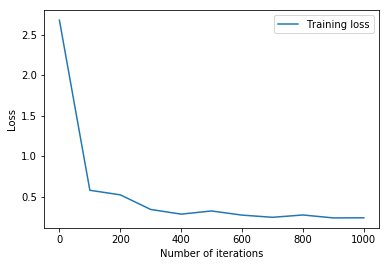

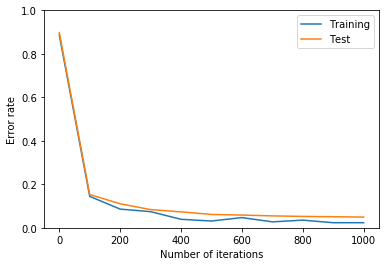

In [12]:
#hyperparamters
n,m = train_x.shape
learning_rate = 0.001
reg_param = 0.2
nh1 = 300
p = train_y.shape[1]
n_iter = 1001
batch_size = 256
print_period = 100
mu = 0.99

#weights 
w1 = np.random.randn(m,nh1)/28
b1 = np.zeros((1,nh1))
w2 = np.random.randn(nh1,p)/np.sqrt(nh1)
b2 = np.zeros((1,p))
weights = [w1,b1,w2,b2]

#momentum velocities
vw1 = np.zeros(w1.shape)
vb1 = np.zeros(b1.shape)
vw2 = np.zeros(w2.shape)
vb2 = np.zeros(b2.shape)
velocity = [vw1,vb1,vw2,vb2]

#training the model
train_loss_m = []
test_errs_m = []
train_errs_m = []

for step in range(n_iter):
    k = (step*batch_size) % (n - batch_size)
    batch_x = train_x[k:(k+batch_size)]
    batch_y = train_y[k:(k+batch_size)]
    
    l,logits = compute_loss(batch_x,batch_y,weights,reg_param)
    grads = compute_gradients(batch_x,batch_y,logits,weights,reg_param)
    w1,b1,w2,b2,velocity = update_weights_momentum(weights,grads,learning_rate,velocity,mu)
    weights = [w1,b1,w2,b2]
    
    if step%print_period ==0:
        train_loss_m.append(l)
        print "Training loss at step %d is %.2f" %(step,l)
        train_err =1.0 - compute_accuracy(batch_x,batch_y,weights)
        test_err =1.0 - compute_accuracy(test_x,test_y,weights)
        #print "Train accuracy at step %d is %.2f%%"  %(step,100.0*train_acc)
        print "Test accuracy at step %d is %.2f%%" %(step,100.0*(1.0-test_err))
        print '\n'
        train_errs_m.append(train_err)
        test_errs_m.append(test_err)

plt.plot(np.arange(0,n_iter,100),train_loss_m,label = 'Training loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_iter,100),train_errs_m,label = 'Training')
plt.plot(np.arange(0,n_iter,100),test_errs_m,label = 'Test')
plt.ylim(0,1)
plt.xlabel('Number of iterations')
plt.ylabel('Error rate')
plt.legend()

Text(0.5,1,u'Loss per iteration')

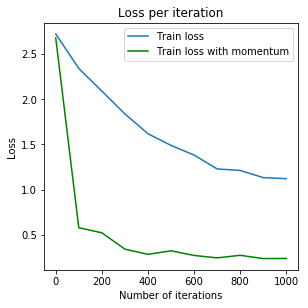

In [13]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ax1.plot(np.arange(0,n_iter,100),train_loss,label = 'Train loss')
ax1.plot(np.arange(0,n_iter,100),train_loss_m,label = 'Train loss with momentum',c='green')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per iteration')

# ax3 = plt.subplot(2,2,3)
# ax3.plot(np.arange(0,n_iter,100),train_errs,label = 'Training')
# ax3.plot(np.arange(0,n_iter,100),test_errs,label = 'Test')
# plt.ylim(0,1)
# plt.xlabel('Number of iterations')
# plt.ylabel('Error rate')
# plt.legend()
# plt.title('Error rate per iteration')

# ax4 = plt.subplot(2,2,4)
# ax4.plot(np.arange(0,n_iter,100),train_errs_m,label = 'Training')
# ax4.plot(np.arange(0,n_iter,100),test_errs_m,label = 'Test')
# plt.ylim(0,1)
# plt.xlabel('Number of iterations')
# plt.ylabel('Error rate')
# plt.legend()
# plt.title('Error rate per iteration using momentum method')